In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)


Mounted at /content/drive


In [2]:
from tqdm.auto import tqdm
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [3]:
import nltk
nltk.download('stopwords')
!pip install np_utils==0.5.12.1

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for np_utils: filename=np_utils-0.5.12.1-py3-none-any.whl size=57115 sha256=0b1506ff60bec07f33f6bc5bb942c7b11a13b64e9cd3c05561389648fd013f8f
  Stored in directory: /root/.cache/pip/wheels/be/92/8d/342430792f441edcf7b5f7dca33fea947a3f97cd164e93a42e
Successfully built np_utils


In [4]:
import numpy as np
import pandas as pd
from plotly.offline import iplot
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))

### **PREPRCESSING**

In [5]:
df = pd.read_csv('/content/drive/MyDrive/combined_dataset.csv')
label_mapping = {
   1 : 'neoplasms',
    2:'digestive',
    3: 'nervous',
    4: 'cardiovascular',
    5: 'general',
}

# Replace the values in the 'condition_label' column based on the mapping
df['condition_label'] = df['condition_label'].map(label_mapping)
df.head()

,condition_label,medical_abstract
0,general,Tissue changes around loose prostheses. A cani...
1,neoplasms,Neuropeptide Y and neuron-specific enolase lev...
2,digestive,"Sexually transmitted diseases of the colon, re..."
3,neoplasms,Lipolytic factors associated with murine and h...
4,nervous,Does carotid restenosis predict an increased r...


In [6]:
df = df.rename(columns={'condition_label': 'category'})
df = df.rename(columns={'medical_abstract': 'text'})
df['text'] = df['text'].str.lower()
df.head(1000)

,category,text
0,general,tissue changes around loose prostheses. a cani...
1,neoplasms,neuropeptide y and neuron-specific enolase lev...
2,digestive,"sexually transmitted diseases of the colon, re..."
3,neoplasms,lipolytic factors associated with murine and h...
4,nervous,does carotid restenosis predict an increased r...
...,...,...
995,cardiovascular,hemopump support for the failing heart. under ...
996,nervous,signs distinguishing spasmus nutans (with and ...
997,cardiovascular,clinicopathologic studies of children who die ...
998,neoplasms,the interferon system in carcinoma of the cerv...


In [7]:
df.shape

(14438, 2)

In [8]:
df.category.value_counts()

general           4805
neoplasms         3163
cardiovascular    3051
nervous           1925
digestive         1494
Name: category, dtype: int64

In [9]:
def example_complain(index):
    example = df[df.index == index][['category', 'text']].values[0]
    if len(example) > 0:
        print(example[0])
        print()
        print('Category:', example[1])


example_complain(1150)

general

Category: potential value of hormone receptor assay in carcinoma in situ of breast. the estrogen receptor (er) expression of invasive breast cancer has been extensively studied both biochemically and with specific monoclonal antibodies against er. relatively few studies have attempted to characterize er pattern in breast carcinoma in situ (cis) and in other premalignant lesions. in the current study, the authors investigated the pattern of er expression in 62 cases of breast cis, 30 of which had a component of invasive cancer, and 36 cases of atypical hyperplasia. paraffin sections of formalin-fixed breast tissue underwent enzyme pretreatment to expose nuclear antigenic sites as previously described. breast tissues then underwent estrogen immunocytochemical assay using specific monoclonal antibodies (abbott laboratory, chicago, il). the cases were evaluated for heterogeneity, intensity of staining, and percentage of er-positive cells. an attempt was made to study the relation 

In [10]:
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string

        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing.
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
df['category'] = df['category'].apply(clean_text)



In [11]:
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH =512
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 38625 unique tokens.


In [12]:
X = tokenizer.texts_to_sequences(df['text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)


Shape of data tensor: (14438, 512)


In [13]:
Y = pd.get_dummies(df['category']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (14438, 5)


In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(12994, 512) (12994, 5)
(1444, 512) (1444, 5)


# **LSTM**

In [16]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(256, dropout=0.5, recurrent_dropout=0.2))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 512, 100)          5000000   
                                                                 
 spatial_dropout1d_1 (Spati  (None, 512, 100)          0         
 alDropout1D)                                                    
                                                                 
 lstm_1 (LSTM)               (None, 256)               365568    
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 5366853 (20.47 MB)
Trainable params: 5366853 (20.47 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [17]:
epochs = 20
batch_size = 32

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])



Epoch 1/20
366/366 [==============================] - 994s 3s/step - loss: 1.4378 - accuracy: 0.3889 - val_loss: 1.4063 - val_accuracy: 0.3938
Epoch 2/20
366/366 [==============================] - 960s 3s/step - loss: 1.1650 - accuracy: 0.5258 - val_loss: 1.4142 - val_accuracy: 0.3846
Epoch 3/20
366/366 [==============================] - 956s 3s/step - loss: 0.9831 - accuracy: 0.6086 - val_loss: 1.2569 - val_accuracy: 0.4938
Epoch 4/20
366/366 [==============================] - 953s 3s/step - loss: 0.8241 - accuracy: 0.6765 - val_loss: 1.3238 - val_accuracy: 0.4723
Epoch 5/20
366/366 [==============================] - 953s 3s/step - loss: 0.7708 - accuracy: 0.6923 - val_loss: 1.5050 - val_accuracy: 0.4138
Epoch 6/20
366/366 [==============================] - 943s 3s/step - loss: 0.6912 - accuracy: 0.7218 - val_loss: 1.5273 - val_accuracy: 0.4300


46/46 [==============================] - 8s 163ms/step - loss: 1.4667 - accuracy: 0.4404
Test set
  Loss: 1.467
  Accuracy: 0.440


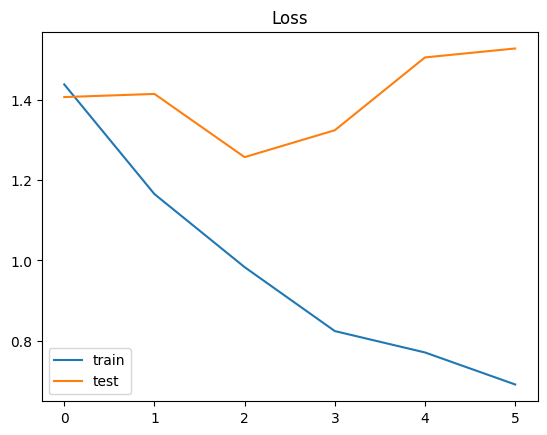

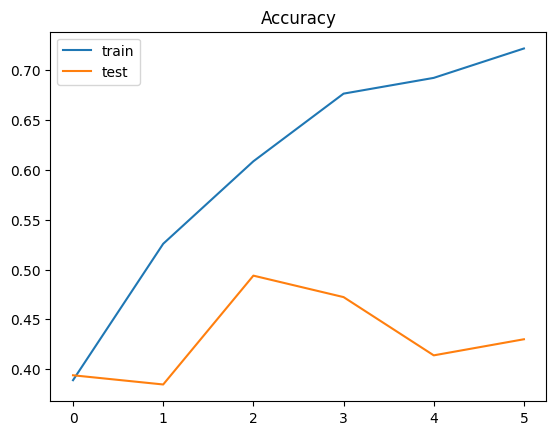

In [18]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))


plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();


plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [19]:
momodel.load('/content/drive/MyDrive/lstm')

OSError: ignored

In [ ]:
model.save('/content/drive/MyDrive/lstmfi.keras')